# Preprocessing
## General stuff
*(Loading data, prepare for future working)*

In [372]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

In [373]:
# ############LOADING BASEDATASET #########################

data_folder = "../data"
dataset = "credit_train"
file_type = ".csv"
df = pd.read_csv(data_folder+"/"+dataset+file_type)

In [374]:
# removing unwanted features like LOanID and CustomerID
df = df.drop(df[['Loan ID', 'Customer ID']], axis=1)

In [375]:
# Drop record if it does not have at least 'n' values that are **not** NaN out of 17 columns
# finding val of 'n', we will see how many records are dropped at each threshlod val
threshold = 0

for i in range(1, 18):
    mod_df = df.dropna(thresh=i)
    total_rows = mod_df.shape[0]
    if total_rows < 1: 
        break
    else: 
        threshold = i
        
threshold

17

In [376]:
# remove NAN values from the dataframe
df = df.dropna(thresh=threshold)

In [377]:
# Convert Loan Status to 0 or 1
df['Loan Status'] = [0 if x == 'Fully Paid' else 1 for x in  df['Loan Status']]

In [378]:
# encode features
label_encoder = preprocessing.LabelEncoder()
df['Loan Status'] = df['Loan Status'].astype(np.str)
df['Loan Status'] = label_encoder.fit_transform(df['Loan Status']).astype(np.float64)

label_encoder1 = preprocessing.LabelEncoder()
df['Term'] = label_encoder1.fit_transform(df['Term']).astype(np.float64)

encoder = preprocessing.OneHotEncoder()
encoded = pd.DataFrame(encoder.fit_transform(df[['Home Ownership', 'Purpose']]).toarray(),
                       columns=encoder.get_feature_names(['Home Ownership', 'Purpose']))
encoded.info()
#df = df.drop(df[['Home Ownership', 'Purpose']], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36423 entries, 0 to 36422
Data columns (total 20 columns):
Home Ownership_HaveMortgage     36423 non-null float64
Home Ownership_Home Mortgage    36423 non-null float64
Home Ownership_Own Home         36423 non-null float64
Home Ownership_Rent             36423 non-null float64
Purpose_Business Loan           36423 non-null float64
Purpose_Buy House               36423 non-null float64
Purpose_Buy a Car               36423 non-null float64
Purpose_Debt Consolidation      36423 non-null float64
Purpose_Educational Expenses    36423 non-null float64
Purpose_Home Improvements       36423 non-null float64
Purpose_Medical Bills           36423 non-null float64
Purpose_Other                   36423 non-null float64
Purpose_Take a Trip             36423 non-null float64
Purpose_major_purchase          36423 non-null float64
Purpose_moving                  36423 non-null float64
Purpose_other                   36423 non-null float64
Purpose_ren

In [379]:
import importlib.util
spec = importlib.util.spec_from_file_location("module.name", "../functions.py")
functions = importlib.util.module_from_spec(spec)
spec.loader.exec_module(functions)

In [380]:
# Apply functions
df['Years in current job'] = df['Years in current job'].apply(functions.f).astype(np.float64)
df['Credit Score'] = df['Credit Score'].apply(functions.cs)

# #fill NaN values groupby more related column
df['Credit Score'].fillna(value=df.groupby('Home Ownership')['Credit Score'].transform('median'), inplace=True)
df['Annual Income'].fillna(value=df.groupby('Purpose')['Annual Income'].transform('median'), inplace=True)
df['Years in current job'].fillna(value=df.groupby('Home Ownership')['Years in current job'].transform('median'),
                                  inplace=True)
df['Months since last delinquent'].fillna(0, inplace=True)
df['Maximum Open Credit'].fillna(value=df.groupby('Home Ownership')['Maximum Open Credit'].transform('median'),
                                 inplace=True)
df['Bankruptcies'].fillna(0, inplace=True)
df['Tax Liens'].fillna(0, inplace=True)

df["Monthly Income"] = df.apply(lambda row: functions.mi(row), axis=1)
df["Credit Ration per Year"]= df.apply(lambda row: functions.cr(row), axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36423 entries, 2 to 99997
Data columns (total 19 columns):
Loan Status                     36423 non-null float64
Current Loan Amount             36423 non-null float64
Term                            36423 non-null float64
Credit Score                    36423 non-null float64
Annual Income                   36423 non-null float64
Years in current job            36423 non-null float64
Home Ownership                  36423 non-null object
Purpose                         36423 non-null object
Monthly Debt                    36423 non-null float64
Years of Credit History         36423 non-null float64
Months since last delinquent    36423 non-null float64
Number of Open Accounts         36423 non-null float64
Number of Credit Problems       36423 non-null float64
Current Credit Balance          36423 non-null float64
Maximum Open Credit             36423 non-null float64
Bankruptcies                    36423 non-null float64
Tax Liens    

In [381]:
# merging categorical encoded dataframe with the main dataframe and deleting unwanted features
df = df.reset_index(drop=True).merge(encoded.reset_index(drop=True), left_index=True, right_index=True)
# remove it from the dataframe so it only contains the features that our model should use
df = df.drop(df[['Home Ownership', 'Purpose']], axis=1)
df.head(10)

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,...,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
0,0.0,99999999.0,1.0,741.0,2231892.0,8.0,29200.53,14.9,29.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,217646.0,1.0,730.0,1184194.0,0.0,10855.08,19.6,10.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,548746.0,1.0,678.0,2559110.0,2.0,18660.28,22.6,33.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,99999999.0,1.0,728.0,714628.0,3.0,11851.06,16.0,76.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,99999999.0,1.0,740.0,776188.0,0.0,11578.22,8.5,25.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,234124.0,1.0,727.0,693234.0,10.0,14211.24,24.7,46.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,666204.0,0.0,723.0,1821967.0,10.0,17612.24,22.0,34.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,317108.0,0.0,687.0,1133274.0,8.0,9632.81,17.4,53.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,465410.0,0.0,688.0,1722654.0,3.0,15647.45,22.3,30.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,99999999.0,1.0,746.0,1749748.0,10.0,19247.19,20.0,32.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


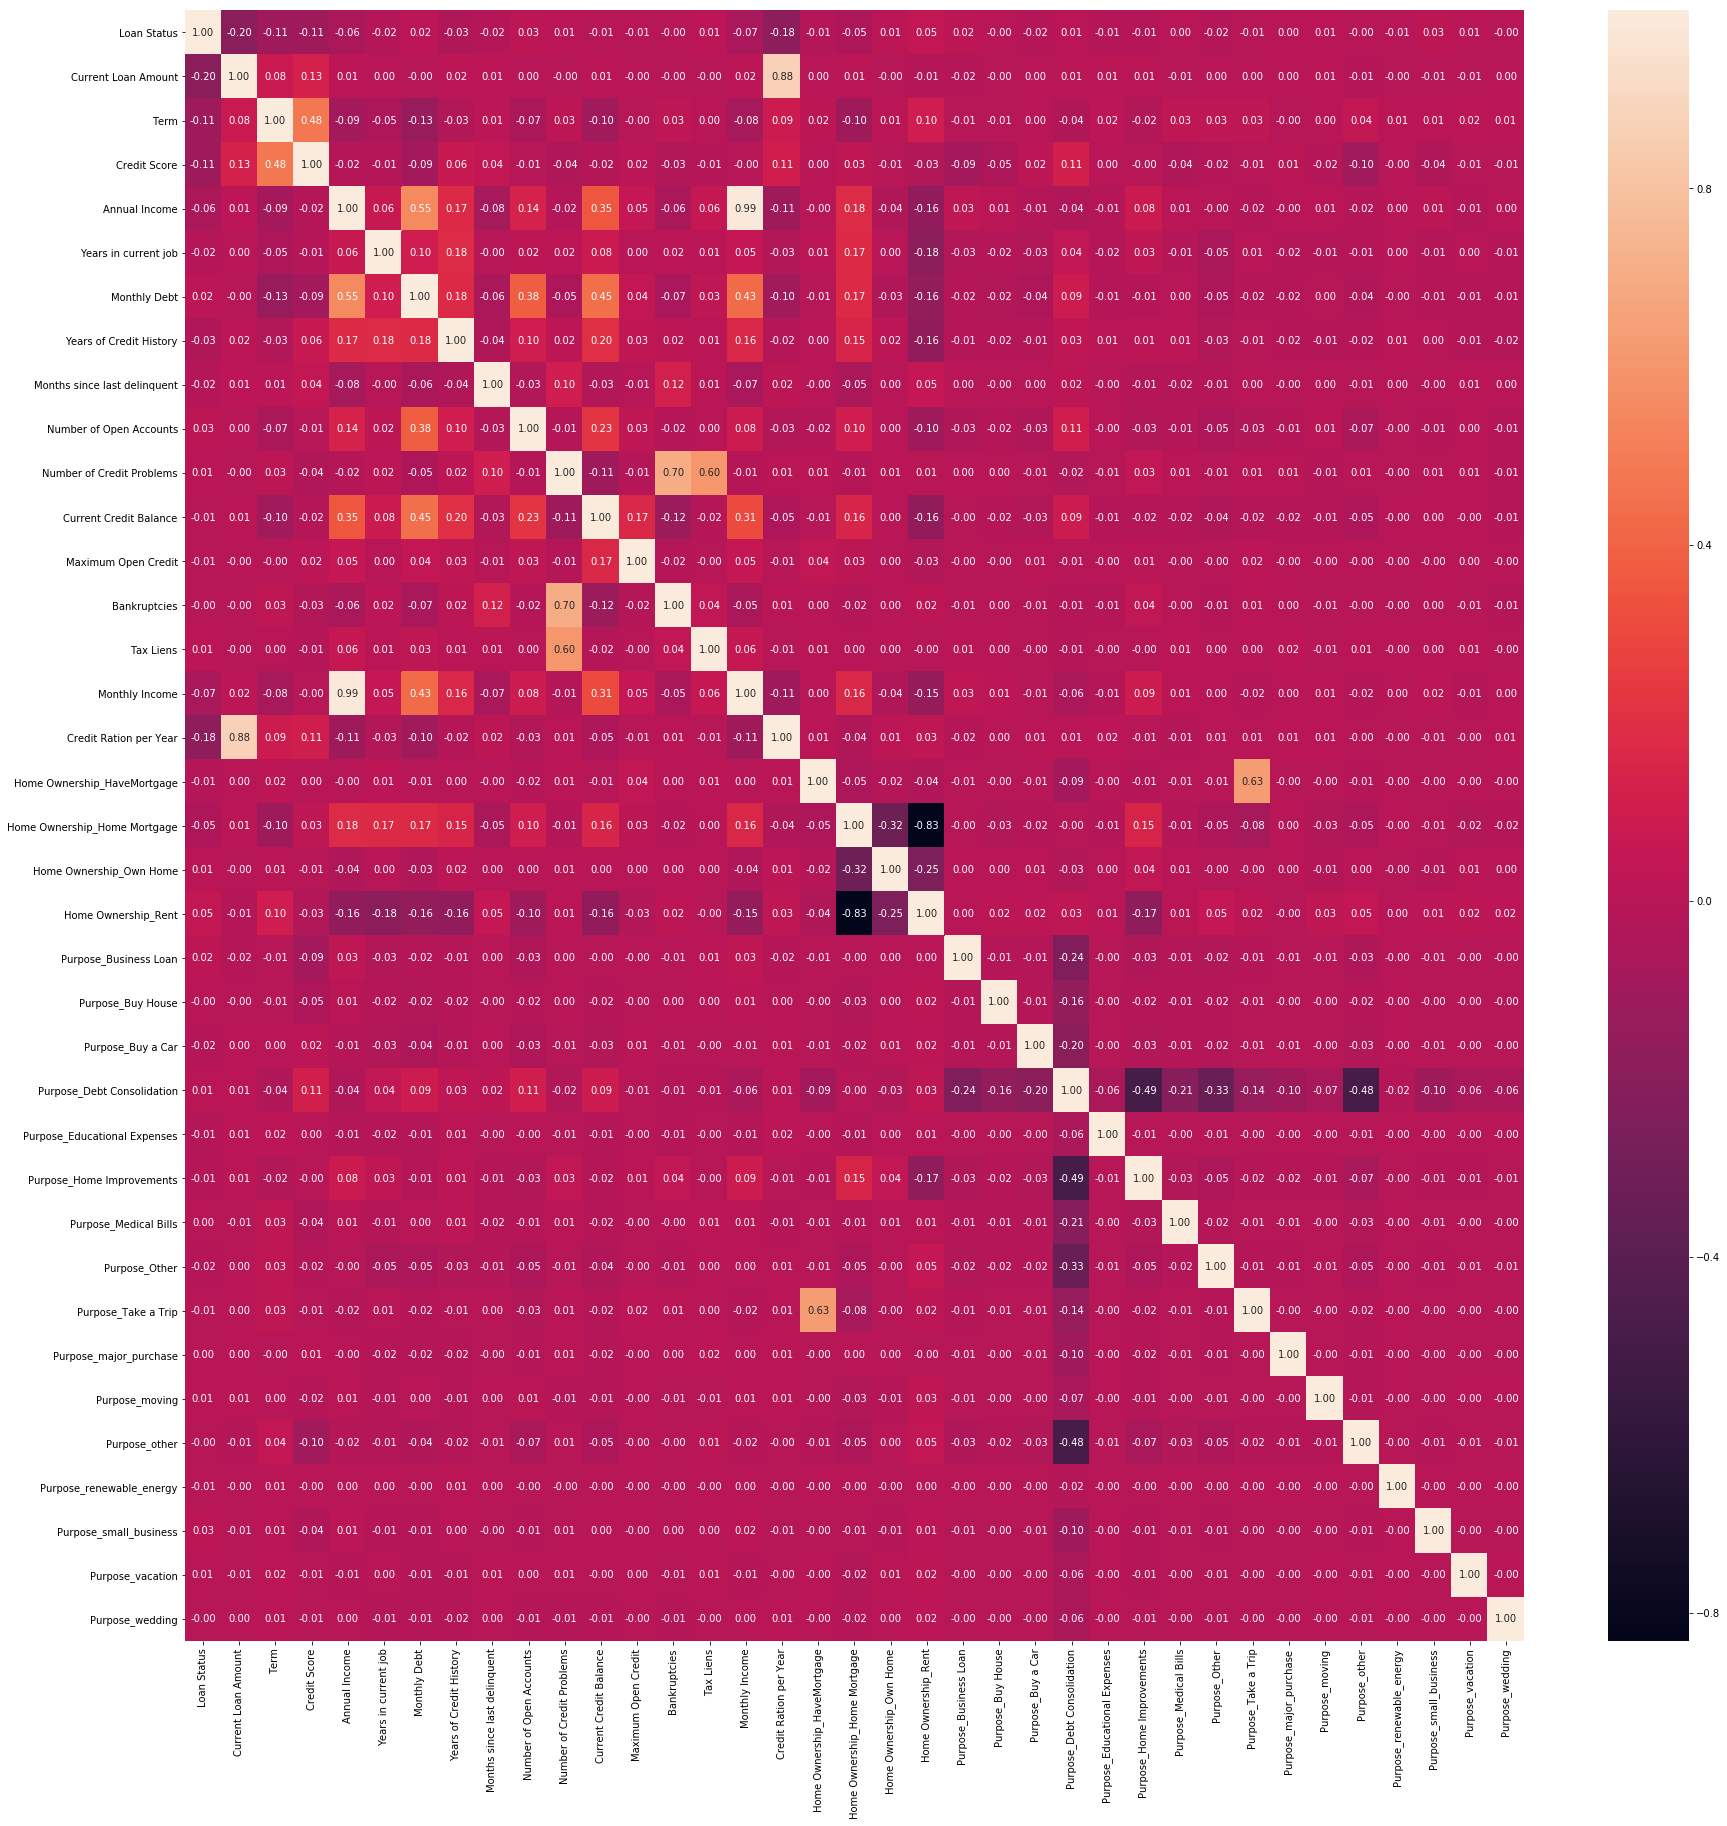

In [382]:
# show correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

In [383]:
#save as processed 
df.to_csv(data_folder + "/" + dataset + "_processed" + file_type)

## Basic cleaning
*(remove outliers)*

In [384]:
#Decide which categorical variables you want to use in model

for col_name in df.columns:
        unique_cat = len(df[col_name].unique())
        print("Feature {0} has {1} unique categories".format(col_name, unique_cat))
df.info()

Feature Loan Status has 2 unique categories
Feature Current Loan Amount has 13914 unique categories
Feature Term has 2 unique categories
Feature Credit Score has 167 unique categories
Feature Annual Income has 20645 unique categories
Feature Years in current job has 11 unique categories
Feature Monthly Debt has 27103 unique categories
Feature Years of Credit History has 452 unique categories
Feature Months since last delinquent has 108 unique categories
Feature Number of Open Accounts has 46 unique categories
Feature Number of Credit Problems has 11 unique categories
Feature Current Credit Balance has 18486 unique categories
Feature Maximum Open Credit has 22109 unique categories
Feature Bankruptcies has 8 unique categories
Feature Tax Liens has 10 unique categories
Feature Monthly Income has 29269 unique categories
Feature Credit Ration per Year has 27196 unique categories
Feature Home Ownership_HaveMortgage has 2 unique categories
Feature Home Ownership_Home Mortgage has 2 unique cat

In [385]:
from sklearn.neighbors.kde import KernelDensity
def kde_sklearn(x, bandwidth=0.15, **kwargs):
    x_grid = np.linspace(x.min() - 1, x.max() + 1, 500)
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf), x_grid

In [386]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 -q1
    
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    
    outlier_indices = list(x.index[(x<floor) | (x>ceiling)])
    return outlier_indices

In [387]:
def detect_outlier(col):
    threshold=3
    mean = np.mean(col.values)
    std = np.std(col.values)
    
    outlier_indices = list(col.index[(np.abs((col - mean)/std) > threshold)])
    return outlier_indices

In [410]:
import itertools
outliers = []
best = 0
best_subset = []
cols = ["Term",
"Credit Score",
"Annual Income",
"Years in current job",
"Monthly Debt",
"Years of Credit History",
"Months since last delinquent",
"Number of Open Accounts",
"Number of Credit Problems",
"Current Credit Balance",
"Maximum Open Credit",
"Bankruptcies",
"Tax Liens",
"Monthly Income",
"Credit Ration per Year"]
counter = 0
for L in range(0, len(cols)+1):
    combinations = itertools.combinations(cols, L)
    print(len(list(combinations)))
    for subset in itertools.combinations(cols, L):
        print(subset)
        outliers = []
        for col_name in df.columns:
            if col_name in subset:
                outliers.append(detect_outlier(df[col_name]))
                outliers.append(find_outliers_tukey(df[col_name]))
        outliers_list = list(itertools.chain.from_iterable(outliers))
        outliers_list = list(dict.fromkeys(outliers_list))
        print("Dataset contains {0} outliers in run {1}".format(len(outliers_list), counter+1))
        df_temp = df.drop(outliers_list)
        corr_abs = abs(df_temp.corr())
        sum = corr_abs["Loan Status"].sum(skipna=True)
        if sum > best:
            best = sum
            best_subset = subset
        counter += 1
        

1
()
Dataset contains 0 outliers in run 1
15
('Term',)
Dataset contains 0 outliers in run 2
('Credit Score',)
Dataset contains 228 outliers in run 3
('Annual Income',)
Dataset contains 311 outliers in run 4
('Years in current job',)
Dataset contains 0 outliers in run 5
('Monthly Debt',)
Dataset contains 291 outliers in run 6
('Years of Credit History',)
Dataset contains 356 outliers in run 7
('Months since last delinquent',)
Dataset contains 1 outliers in run 8
('Number of Open Accounts',)
Dataset contains 524 outliers in run 9
('Number of Credit Problems',)
Dataset contains 0 outliers in run 10
('Current Credit Balance',)
Dataset contains 405 outliers in run 11
('Maximum Open Credit',)
Dataset contains 378 outliers in run 12
('Bankruptcies',)
Dataset contains 0 outliers in run 13
('Tax Liens',)
Dataset contains 0 outliers in run 14
('Monthly Income',)
Dataset contains 388 outliers in run 15
('Credit Ration per Year',)
Dataset contains 15 outliers in run 16
105
('Term', 'Credit Score')

('Number of Credit Problems', 'Tax Liens')
Dataset contains 0 outliers in run 104
('Number of Credit Problems', 'Monthly Income')
Dataset contains 388 outliers in run 105
('Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 15 outliers in run 106
('Current Credit Balance', 'Maximum Open Credit')
Dataset contains 716 outliers in run 107
('Current Credit Balance', 'Bankruptcies')
Dataset contains 405 outliers in run 108
('Current Credit Balance', 'Tax Liens')
Dataset contains 405 outliers in run 109
('Current Credit Balance', 'Monthly Income')
Dataset contains 775 outliers in run 110
('Current Credit Balance', 'Credit Ration per Year')
Dataset contains 420 outliers in run 111
('Maximum Open Credit', 'Bankruptcies')
Dataset contains 378 outliers in run 112
('Maximum Open Credit', 'Tax Liens')
Dataset contains 378 outliers in run 113
('Maximum Open Credit', 'Monthly Income')
Dataset contains 756 outliers in run 114
('Maximum Open Credit', 'Credit Ration per Year')
Datas

('Term', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 378 outliers in run 193
('Term', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 0 outliers in run 194
('Term', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 0 outliers in run 195
('Term', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 388 outliers in run 196
('Term', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 15 outliers in run 197
('Term', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 716 outliers in run 198
('Term', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 405 outliers in run 199
('Term', 'Current Credit Balance', 'Tax Liens')
Dataset contains 405 outliers in run 200
('Term', 'Current Credit Balance', 'Monthly Income')
Dataset contains 775 outliers in run 201
('Term', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 420 outliers in run 202
('Term', 'Maximum Open Credit', 'Bankr

('Credit Score', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 611 outliers in run 274
('Credit Score', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 243 outliers in run 275
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 929 outliers in run 276
('Credit Score', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 619 outliers in run 277
('Credit Score', 'Current Credit Balance', 'Tax Liens')
Dataset contains 619 outliers in run 278
('Credit Score', 'Current Credit Balance', 'Monthly Income')
Dataset contains 984 outliers in run 279
('Credit Score', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 634 outliers in run 280
('Credit Score', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 605 outliers in run 281
('Credit Score', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 605 outliers in run 282
('Credit Score', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 

('Annual Income', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 326 outliers in run 355
('Annual Income', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 454 outliers in run 356
('Years in current job', 'Monthly Debt', 'Years of Credit History')
Dataset contains 635 outliers in run 357
('Years in current job', 'Monthly Debt', 'Months since last delinquent')
Dataset contains 292 outliers in run 358
('Years in current job', 'Monthly Debt', 'Number of Open Accounts')
Dataset contains 796 outliers in run 359
('Years in current job', 'Monthly Debt', 'Number of Credit Problems')
Dataset contains 291 outliers in run 360
('Years in current job', 'Monthly Debt', 'Current Credit Balance')
Dataset contains 670 outliers in run 361
('Years in current job', 'Monthly Debt', 'Maximum Open Credit')
Dataset contains 657 outliers in run 362
('Years in current job', 'Monthly Debt', 'Bankruptcies')
Dataset contains 291 outliers in run 363
('Years in current job', 'Monthly Debt', 'Tax

('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 796 outliers in run 429
('Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 1160 outliers in run 430
('Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 1114 outliers in run 431
('Monthly Debt', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 796 outliers in run 432
('Monthly Debt', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 796 outliers in run 433
('Monthly Debt', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1151 outliers in run 434
('Monthly Debt', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 811 outliers in run 435
('Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 670 outliers in run 436
('Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 657 outliers in run 437
('Monthly Debt', 'Number of 

('Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 389 outliers in run 504
('Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 16 outliers in run 505
('Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 717 outliers in run 506
('Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 406 outliers in run 507
('Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 406 outliers in run 508
('Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 776 outliers in run 509
('Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 421 outliers in run 510
('Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 379 outliers in run 511
('Months since last delinquent', 'Maximum 

('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts')
Dataset contains 1043 outliers in run 581
('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems')
Dataset contains 537 outliers in run 582
('Term', 'Credit Score', 'Annual Income', 'Current Credit Balance')
Dataset contains 910 outliers in run 583
('Term', 'Credit Score', 'Annual Income', 'Maximum Open Credit')
Dataset contains 901 outliers in run 584
('Term', 'Credit Score', 'Annual Income', 'Bankruptcies')
Dataset contains 537 outliers in run 585
('Term', 'Credit Score', 'Annual Income', 'Tax Liens')
Dataset contains 537 outliers in run 586
('Term', 'Credit Score', 'Annual Income', 'Monthly Income')
Dataset contains 662 outliers in run 587
('Term', 'Credit Score', 'Annual Income', 'Credit Ration per Year')
Dataset contains 552 outliers in run 588
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt')
Dataset contains 515 outliers in run 589
('Term', 'Credit Score', 'Years in current job', 'Y

('Term', 'Annual Income', 'Years in current job', 'Years of Credit History')
Dataset contains 662 outliers in run 656
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent')
Dataset contains 312 outliers in run 657
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts')
Dataset contains 821 outliers in run 658
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems')
Dataset contains 311 outliers in run 659
('Term', 'Annual Income', 'Years in current job', 'Current Credit Balance')
Dataset contains 698 outliers in run 660
('Term', 'Annual Income', 'Years in current job', 'Maximum Open Credit')
Dataset contains 676 outliers in run 661
('Term', 'Annual Income', 'Years in current job', 'Bankruptcies')
Dataset contains 311 outliers in run 662
('Term', 'Annual Income', 'Years in current job', 'Tax Liens')
Dataset contains 311 outliers in run 663
('Term', 'Annual Income', 'Years in current job', 'Monthly Income')
Dataset con

('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent')
Dataset contains 357 outliers in run 731
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts')
Dataset contains 869 outliers in run 732
('Term', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems')
Dataset contains 356 outliers in run 733
('Term', 'Years in current job', 'Years of Credit History', 'Current Credit Balance')
Dataset contains 747 outliers in run 734
('Term', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit')
Dataset contains 719 outliers in run 735
('Term', 'Years in current job', 'Years of Credit History', 'Bankruptcies')
Dataset contains 356 outliers in run 736
('Term', 'Years in current job', 'Years of Credit History', 'Tax Liens')
Dataset contains 356 outliers in run 737
('Term', 'Years in current job', 'Years of Credit History', 'Monthly Income')
Dataset contains 738 outliers in run 738
('Term',

('Term', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 291 outliers in run 802
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 291 outliers in run 803
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 656 outliers in run 804
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 306 outliers in run 805
('Term', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 975 outliers in run 806
('Term', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 670 outliers in run 807
('Term', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens')
Dataset contains 670 outliers in run 808
('Term', 'Monthly Debt', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1017 outliers in run 809
('Term', 'Monthly Debt', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 685 outliers i

('Term', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 406 outliers in run 871
('Term', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 406 outliers in run 872
('Term', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 776 outliers in run 873
('Term', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 421 outliers in run 874
('Term', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 379 outliers in run 875
('Term', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 379 outliers in run 876
('Term', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 757 outliers in run 877
('Term', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 392 outliers in run 878
('

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History')
Dataset contains 880 outliers in run 942
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent')
Dataset contains 538 outliers in run 943
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts')
Dataset contains 1043 outliers in run 944
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems')
Dataset contains 537 outliers in run 945
('Credit Score', 'Annual Income', 'Years in current job', 'Current Credit Balance')
Dataset contains 910 outliers in run 946
('Credit Score', 'Annual Income', 'Years in current job', 'Maximum Open Credit')
Dataset contains 901 outliers in run 947
('Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies')
Dataset contains 537 outliers in run 948
('Credit Score', 'Annual Income', 'Years in current job', 'Tax Liens')
Dataset contains 537 outliers in run 949
('Credit Score

('Credit Score', 'Years in current job', 'Monthly Debt', 'Current Credit Balance')
Dataset contains 882 outliers in run 1011
('Credit Score', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit')
Dataset contains 880 outliers in run 1012
('Credit Score', 'Years in current job', 'Monthly Debt', 'Bankruptcies')
Dataset contains 515 outliers in run 1013
('Credit Score', 'Years in current job', 'Monthly Debt', 'Tax Liens')
Dataset contains 515 outliers in run 1014
('Credit Score', 'Years in current job', 'Monthly Debt', 'Monthly Income')
Dataset contains 875 outliers in run 1015
('Credit Score', 'Years in current job', 'Monthly Debt', 'Credit Ration per Year')
Dataset contains 530 outliers in run 1016
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent')
Dataset contains 577 outliers in run 1017
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts')
Dataset contains 1085 outliers in run 1018
('Cr

('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Monthly Income')
Dataset contains 876 outliers in run 1077
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 531 outliers in run 1078
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 1016 outliers in run 1079
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 1368 outliers in run 1080
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 1333 outliers in run 1081
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 1016 outliers in run 1082
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 1016 outliers in run 1083
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1366 outliers in run 1084

('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 749 outliers in run 1143
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 1123 outliers in run 1144
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 1075 outliers in run 1145
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 749 outliers in run 1146
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 749 outliers in run 1147
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1122 outliers in run 1148
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 764 outliers in run 1149
('Credit Score', 'Mo

('Credit Score', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 626 outliers in run 1206
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 929 outliers in run 1207
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 929 outliers in run 1208
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1287 outliers in run 1209
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 942 outliers in run 1210
('Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 619 outliers in run 1211
('Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 984 outliers in run 1212
('Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 634 outliers in run 1213
('

('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 676 outliers in run 1272
('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 676 outliers in run 1273
('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 801 outliers in run 1274
('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 689 outliers in run 1275
('Annual Income', 'Years in current job', 'Bankruptcies', 'Tax Liens')
Dataset contains 311 outliers in run 1276
('Annual Income', 'Years in current job', 'Bankruptcies', 'Monthly Income')
Dataset contains 439 outliers in run 1277
('Annual Income', 'Years in current job', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 326 outliers in run 1278
('Annual Income', 'Years in current job', 'Tax Liens', 'Monthly Income')
Dataset contains 439 outliers in run 1279
('Annual Income', 'Years in

Dataset contains 1162 outliers in run 1338
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 1162 outliers in run 1339
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1286 outliers in run 1340
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 1176 outliers in run 1341
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1035 outliers in run 1342
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1012 outliers in run 1343
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 662 outliers in run 1344
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 662 outliers in run 1345
('Annual In

('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1208 outliers in run 1401
('Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1139 outliers in run 1402
('Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1139 outliers in run 1403
('Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1264 outliers in run 1404
('Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1152 outliers in run 1405
('Annual Income', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 821 outliers in run 1406
('Annual Income', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 949 outliers in run 1407
('Annual Income', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 83

('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 796 outliers in run 1467
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 796 outliers in run 1468
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1151 outliers in run 1469
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 811 outliers in run 1470
('Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 670 outliers in run 1471
('Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 657 outliers in run 1472
('Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 291 outliers in run 1473
('Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens')
Da

('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 852 outliers in run 1530
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 525 outliers in run 1531
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 525 outliers in run 1532
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 903 outliers in run 1533
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 540 outliers in run 1534
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 406 outliers in run 1535
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset con

('Years in current job', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 15 outliers in run 1590
('Years in current job', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 403 outliers in run 1591
('Years in current job', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 716 outliers in run 1592
('Years in current job', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 716 outliers in run 1593
('Years in current job', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1079 outliers in run 1594
('Years in current job', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 729 outliers in run 1595
('Years in current job', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 405 outliers in run 1596
('Years in current job', 'Current Credit Balance', 'Bankruptcies',

('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1152 outliers in run 1653
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 812 outliers in run 1654
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 671 outliers in run 1655
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 658 outliers in run 1656
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 292 outliers in run 1657
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 292 outliers in run 1658
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 657 outliers in run 1659
('Monthly Debt', 'Month

('Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 670 outliers in run 1716
('Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1017 outliers in run 1717
('Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 685 outliers in run 1718
('Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1017 outliers in run 1719
('Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 685 outliers in run 1720
('Monthly Debt', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1032 outliers in run 1721
('Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 657 outliers in run 1722
('Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1012 outliers in run 1723
('Monthly Debt', 'Maximum Open Credit', 

('Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 883 outliers in run 1777
('Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 1241 outliers in run 1778
('Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 883 outliers in run 1779
('Years of Credit History', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1255 outliers in run 1780
('Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1045 outliers in run 1781
('Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 747 outliers in run 1782
('Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 747 outliers in run 1783
('Years of Credit History'

('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 717 outliers in run 1837
('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 406 outliers in run 1838
('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 406 outliers in run 1839
('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 776 outliers in run 1840
('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 421 outliers in run 1841
('Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 379 outliers in run 1842
('Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset conta

('Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1221 outliers in run 1898
('Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 864 outliers in run 1899
('Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1221 outliers in run 1900
('Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 864 outliers in run 1901
('Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1234 outliers in run 1902
('Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 902 outliers in run 1903
('Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 539 outliers in run 1904
('Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset cont

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Credit Ration per Year')
Dataset contains 797 outliers in run 1962
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent')
Dataset contains 881 outliers in run 1963
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts')
Dataset contains 1376 outliers in run 1964
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems')
Dataset contains 880 outliers in run 1965
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Current Credit Balance')
Dataset contains 1240 outliers in run 1966
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit')
Dataset contains 1229 outliers in run 1967
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Bankruptcies')
Dataset contains 880 outliers in run 1968
('Term', 'Credit Score', 'Annual Income', 'Years of 

('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Tax Liens')
Dataset contains 576 outliers in run 2024
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Monthly Income')
Dataset contains 953 outliers in run 2025
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Credit Ration per Year')
Dataset contains 590 outliers in run 2026
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 749 outliers in run 2027
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 229 outliers in run 2028
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 620 outliers in run 2029
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 606 outliers in r

('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 1016 outliers in run 2084
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1366 outliers in run 2085
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 1031 outliers in run 2086
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 882 outliers in run 2087
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 880 outliers in run 2088
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 515 outliers in run 2089
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 515 outliers in run 2090
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Monthly Incom

Dataset contains 1123 outliers in run 2145
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 1075 outliers in run 2146
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 749 outliers in run 2147
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 749 outliers in run 2148
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1122 outliers in run 2149
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 764 outliers in run 2150
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 620 outliers in run 2151
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit 

('Term', 'Credit Score', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 626 outliers in run 2207
('Term', 'Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 929 outliers in run 2208
('Term', 'Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 929 outliers in run 2209
('Term', 'Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1287 outliers in run 2210
('Term', 'Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 942 outliers in run 2211
('Term', 'Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 619 outliers in run 2212
('Term', 'Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 984 outliers in run 2213
('Term', 'Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Credi

('Term', 'Annual Income', 'Years in current job', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 698 outliers in run 2269
('Term', 'Annual Income', 'Years in current job', 'Current Credit Balance', 'Tax Liens')
Dataset contains 698 outliers in run 2270
('Term', 'Annual Income', 'Years in current job', 'Current Credit Balance', 'Monthly Income')
Dataset contains 820 outliers in run 2271
('Term', 'Annual Income', 'Years in current job', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 713 outliers in run 2272
('Term', 'Annual Income', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 676 outliers in run 2273
('Term', 'Annual Income', 'Years in current job', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 676 outliers in run 2274
('Term', 'Annual Income', 'Years in current job', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 801 outliers in run 2275
('Term', 'Annual Income', 'Years in current job', 'Maximum Open

('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 1013 outliers in run 2331
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 663 outliers in run 2332
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens')
Dataset contains 663 outliers in run 2333
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income')
Dataset contains 787 outliers in run 2334
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 677 outliers in run 2335
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 1162 outliers in run 2336
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance')
Dataset co

('Term', 'Annual Income', 'Months since last delinquent', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 455 outliers in run 2391
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1193 outliers in run 2392
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1139 outliers in run 2393
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 821 outliers in run 2394
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 821 outliers in run 2395
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 949 outliers in run 2396
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 836 outliers 

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies')
Dataset contains 635 outliers in run 2453
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Tax Liens')
Dataset contains 635 outliers in run 2454
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Monthly Income')
Dataset contains 994 outliers in run 2455
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Credit Ration per Year')
Dataset contains 649 outliers in run 2456
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 797 outliers in run 2457
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 292 outliers in run 2458
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 671 outliers in run 2459
('Te

('Term', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 738 outliers in run 2512
('Term', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 370 outliers in run 2513
('Term', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1045 outliers in run 2514
('Term', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 747 outliers in run 2515
('Term', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 747 outliers in run 2516
('Term', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1111 outliers in run 2517
('Term', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Credit Ration per Year'

('Term', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1221 outliers in run 2570
('Term', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 864 outliers in run 2571
('Term', 'Years in current job', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 524 outliers in run 2572
('Term', 'Years in current job', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 902 outliers in run 2573
('Term', 'Years in current job', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 539 outliers in run 2574
('Term', 'Years in current job', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 902 outliers in run 2575
('Term', 'Years in current job', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 539 outliers in run 2576
('Term', 'Years in c

('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1001 outliers in run 2628
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 986 outliers in run 2629
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 635 outliers in run 2630
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 635 outliers in run 2631
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 994 outliers in run 2632
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 649 outliers in run 2633
('Term', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1293 outliers in run 

('Term', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1175 outliers in run 2687
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1114 outliers in run 2688
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1114 outliers in run 2689
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1461 outliers in run 2690
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1127 outliers in run 2691
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 796 outliers in run 2692
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 1151 outliers in run 2693
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Ban

('Term', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 748 outliers in run 2748
('Term', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1112 outliers in run 2749
('Term', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 762 outliers in run 2750
('Term', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 720 outliers in run 2751
('Term', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 720 outliers in run 2752
('Term', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1092 outliers in run 2753
('Term', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credi

Dataset contains 1111 outliers in run 2804
('Term', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 761 outliers in run 2805
('Term', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1125 outliers in run 2806
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 719 outliers in run 2807
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1091 outliers in run 2808
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 731 outliers in run 2809
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1091 outliers in run 2810
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 731 outl

('Term', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 421 outliers in run 2861
('Term', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 791 outliers in run 2862
('Term', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 379 outliers in run 2863
('Term', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 757 outliers in run 2864
('Term', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 392 outliers in run 2865
('Term', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 757 outliers in run 2866
('Term', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 392 outliers in run

('Term', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 391 outliers in run 2920
('Term', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 756 outliers in run 2921
('Term', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 391 outliers in run 2922
('Term', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 769 outliers in run 2923
('Term', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 388 outliers in run 2924
('Term', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 15 outliers in run 2925
('Term', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 403 outliers in run 2926
('Term', 'Number of Credit Prob

('Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 537 outliers in run 2979
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 537 outliers in run 2980
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 662 outliers in run 2981
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 552 outliers in run 2982
('Credit Score', 'Annual Income', 'Years in current job', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1214 outliers in run 2983
('Credit Score', 'Annual Income', 'Years in current job', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 910 outliers in run 2984
('Credit Score', 'Annual Income', 'Years in current job', 'Current Credit Balance', 'Tax Liens')
Dataset contains 910 o

('Credit Score', 'Annual Income', 'Monthly Debt', 'Bankruptcies', 'Tax Liens')
Dataset contains 782 outliers in run 3037
('Credit Score', 'Annual Income', 'Monthly Debt', 'Bankruptcies', 'Monthly Income')
Dataset contains 907 outliers in run 3038
('Credit Score', 'Annual Income', 'Monthly Debt', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 797 outliers in run 3039
('Credit Score', 'Annual Income', 'Monthly Debt', 'Tax Liens', 'Monthly Income')
Dataset contains 907 outliers in run 3040
('Credit Score', 'Annual Income', 'Monthly Debt', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 797 outliers in run 3041
('Credit Score', 'Annual Income', 'Monthly Debt', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 922 outliers in run 3042
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 1377 outliers in run 3043
('Credit Score', 'Annual Income', 'Years of Credit History', 'Mont

('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 911 outliers in run 3093
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 911 outliers in run 3094
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1030 outliers in run 3095
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 926 outliers in run 3096
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 902 outliers in run 3097
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 902 outliers in run 3098
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly I

('Credit Score', 'Annual Income', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1029 outliers in run 3150
('Credit Score', 'Annual Income', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 925 outliers in run 3151
('Credit Score', 'Annual Income', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1044 outliers in run 3152
('Credit Score', 'Annual Income', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 901 outliers in run 3153
('Credit Score', 'Annual Income', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1023 outliers in run 3154
('Credit Score', 'Annual Income', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 914 outliers in run 3155
('Credit Score', 'Annual Income', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1023 outliers in run 3156
('Credit Score', 'Annual Income', 'Maximum O

('Credit Score', 'Years in current job', 'Monthly Debt', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 890 outliers in run 3207
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 1086 outliers in run 3208
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 577 outliers in run 3209
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 955 outliers in run 3210
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 939 outliers in run 3211
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 577 outliers in run 3212
('Credit Score', 'Years i

('Credit Score', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 635 outliers in run 3261
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 606 outliers in run 3262
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 606 outliers in run 3263
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 979 outliers in run 3264
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 619 outliers in run 3265
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 229 outliers in run 3266
('Credit Score', 'Years in current job', 'Months since last deli

('Credit Score', 'Years in current job', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 984 outliers in run 3315
('Credit Score', 'Years in current job', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 634 outliers in run 3316
('Credit Score', 'Years in current job', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 3317
('Credit Score', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 605 outliers in run 3318
('Credit Score', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 978 outliers in run 3319
('Credit Score', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 618 outliers in run 3320
('Credit Score', 'Years in current job', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 978 outliers in run 3321

('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 881 outliers in run 3372
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 516 outliers in run 3373
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 516 outliers in run 3374
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 876 outliers in run 3375
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 531 outliers in run 3376
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1187 outliers in run 3377
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'C

('Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1186 outliers in run 3428
('Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1186 outliers in run 3429
('Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1521 outliers in run 3430
('Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1199 outliers in run 3431
('Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 882 outliers in run 3432
('Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1224 outliers in run 3433
('Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 897 outliers in run 3434
('Credit Score', '

('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1701 outliers in run 3482
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1447 outliers in run 3483
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1447 outliers in run 3484
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1796 outliers in run 3485
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1461 outliers in run 3486
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1399 outliers in run 3487
('Credit Score', 'Years of Credit History', 'Number

('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1122 outliers in run 3536
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 764 outliers in run 3537
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1387 outliers in run 3538
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1123 outliers in run 3539
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1123 outliers in run 3540
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1478 outliers in run 3541
('Credit Sc

('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1122 outliers in run 3590
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1477 outliers in run 3591
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1137 outliers in run 3592
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1074 outliers in run 3593
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1074 outliers in run 3594
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1439 outliers in run 3595
('Credit Score', 'Number of Open Accounts', 'Number o

Dataset contains 942 outliers in run 3645
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1287 outliers in run 3646
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 942 outliers in run 3647
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1300 outliers in run 3648
('Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 984 outliers in run 3649
('Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 634 outliers in run 3650
('Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 3651
('Credit Score', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
D

('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 1163 outliers in run 3703
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 663 outliers in run 3704
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 1036 outliers in run 3705
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 1013 outliers in run 3706
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 663 outliers in run 3707
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens')
Dataset contains 663 outliers in run 3708
('Ann

('Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 821 outliers in run 3755
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 714 outliers in run 3756
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 677 outliers in run 3757
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 677 outliers in run 3758
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 802 outliers in run 3759
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 690 outliers in run 3760
('Annual Income', 'Years in current job', '

('Annual Income', 'Years in current job', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 713 outliers in run 3811
('Annual Income', 'Years in current job', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 835 outliers in run 3812
('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 676 outliers in run 3813
('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 801 outliers in run 3814
('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 689 outliers in run 3815
('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 801 outliers in run 3816
('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 689 outliers

('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 561 outliers in run 3868
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 561 outliers in run 3869
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 689 outliers in run 3870
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 576 outliers in run 3871
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1223 outliers in run 3872
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 924 outliers in run 3873
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Curr

('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1341 outliers in run 3925
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1235 outliers in run 3926
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 923 outliers in run 3927
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1045 outliers in run 3928
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 938 outliers in run 3929
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1045 outliers in run 3930
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 938 outliers in run 3931
('Annual Income',

('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1521 outliers in run 3979
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1639 outliers in run 3980
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1535 outliers in run 3981
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1468 outliers in run 3982
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1468 outliers in run 3983
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1589 outliers in run 3984
('Annual Income', 'Years of Credit History', 'Number of Ope

('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1455 outliers in run 4033
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1194 outliers in run 4034
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1194 outliers in run 4035
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1316 outliers in run 4036
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1209 outliers in run 4037
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1140 outliers in run 4038
('Annual Income

('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1208 outliers in run 4087
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1139 outliers in run 4088
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1139 outliers in run 4089
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1264 outliers in run 4090
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1152 outliers in run 4091
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 821 outliers in run 4092
('Annual Income', 'Number of Open Accounts', 'Number 

('Annual Income', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 820 outliers in run 4144
('Annual Income', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 713 outliers in run 4145
('Annual Income', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 835 outliers in run 4146
('Annual Income', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 835 outliers in run 4147
('Annual Income', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 801 outliers in run 4148
('Annual Income', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 689 outliers in run 4149
('Annual Income', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 814 outliers in run 4150
('Annual Income', 'Maximum

('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 292 outliers in run 4199
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 657 outliers in run 4200
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 307 outliers in run 4201
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 976 outliers in run 4202
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 671 outliers in run 4203
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 671 outliers in run 4204
('Years in current job', 'Monthly De

('Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 671 outliers in run 4252
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 975 outliers in run 4253
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 975 outliers in run 4254
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1315 outliers in run 4255
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 988 outliers in run 4256
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 670 outliers in run 4257
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dat

('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 869 outliers in run 4304
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1241 outliers in run 4305
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 883 outliers in run 4306
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1499 outliers in run 4307
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1244 outliers in run 4308
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1244 outliers in run 4

('Years in current job', 'Years of Credit History', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 752 outliers in run 4356
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 913 outliers in run 4357
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 852 outliers in run 4358
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 525 outliers in run 4359
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 525 outliers in run 4360
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 903

('Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 392 outliers in run 4407
('Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 770 outliers in run 4408
('Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 389 outliers in run 4409
('Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 16 outliers in run 4410
('Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 404 outliers in run 4411
('Years in current job', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 404 outliers in run 4412
('Years in current job', 'Number of Open Accounts', 'Number

('Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 391 outliers in run 4460
('Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 756 outliers in run 4461
('Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 391 outliers in run 4462
('Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 769 outliers in run 4463
('Years in current job', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 388 outliers in run 4464
('Years in current job', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 15 outliers in run 4465
('Years in current job', 'Number of Credit Problems', 'Bankruptcies', 'Mont

('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 1129 outliers in run 4514
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1478 outliers in run 4515
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 1143 outliers in run 4516
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1731 outliers in run 4517
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1481 outliers in run 4518
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1481 outliers in run 4519
('Monthly Debt', 'Years of Credit History'

('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1115 outliers in run 4568
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 797 outliers in run 4569
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 797 outliers in run 4570
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1152 outliers in run 4571
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 812 outliers in run 4572
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1421 outliers in run 4573

('Monthly Debt', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 672 outliers in run 4622
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1420 outliers in run 4623
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1160 outliers in run 4624
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1160 outliers in run 4625
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1497 outliers in run 4626
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1175 outliers in run 4627
('Monthly Debt', 'Number of Open Accounts', 'N

('Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1315 outliers in run 4679
('Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 988 outliers in run 4680
('Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1315 outliers in run 4681
('Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 988 outliers in run 4682
('Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1328 outliers in run 4683
('Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1017 outliers in run 4684
('Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 685 outliers in run

('Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1046 outliers in run 4730
('Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1403 outliers in run 4731
('Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1058 outliers in run 4732
('Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 748 outliers in run 4733
('Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1112 outliers in run 4734
('Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 762 outliers in run 47

('Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 883 outliers in run 4781
('Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1255 outliers in run 4782
('Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1255 outliers in run 4783
('Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1045 outliers in run 4784
('Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1045 outliers in run 4785
('Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1402 outliers in run 4786
('Years of Credit History', 'Number of Cr

('Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 918 outliers in run 4833
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1178 outliers in run 4834
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1178 outliers in run 4835
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1533 outliers in run 4836
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1191 outliers in run 4837
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 913 outliers

Dataset contains 757 outliers in run 4884
('Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 392 outliers in run 4885
('Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 770 outliers in run 4886
('Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 770 outliers in run 4887
('Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 404 outliers in run 4888
('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1177 outliers in run 4889
('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1177 outliers in run 4890
('Number of Open 

('Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 403 outliers in run 4938
('Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1079 outliers in run 4939
('Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 729 outliers in run 4940
('Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1092 outliers in run 4941
('Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1092 outliers in run 4942
('Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 790 outliers in run 4943
('Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 769 outli

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1023 outliers in run 4992
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 914 outliers in run 4993
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies', 'Tax Liens')
Dataset contains 537 outliers in run 4994
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies', 'Monthly Income')
Dataset contains 662 outliers in run 4995
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 552 outliers in run 4996
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Tax Liens', 'Monthly Income')
Dataset contains 662 outliers in run 4997
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 552

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 1230 outliers in run 5048
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 881 outliers in run 5049
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens')
Dataset contains 881 outliers in run 5050
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income')
Dataset contains 1002 outliers in run 5051
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 895 outliers in run 5052
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 1376 outliers in run 5053
('Term', 'Credit Sc

('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1024 outliers in run 5101
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 915 outliers in run 5102
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 538 outliers in run 5103
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 663 outliers in run 5104
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 553 outliers in run 5105
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Tax Liens', 'Monthly Income')
Dataset contains 663 outliers in run 5106
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Ta

('Term', 'Credit Score', 'Annual Income', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 914 outliers in run 5157
('Term', 'Credit Score', 'Annual Income', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1023 outliers in run 5158
('Term', 'Credit Score', 'Annual Income', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 914 outliers in run 5159
('Term', 'Credit Score', 'Annual Income', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1036 outliers in run 5160
('Term', 'Credit Score', 'Annual Income', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 662 outliers in run 5161
('Term', 'Credit Score', 'Annual Income', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 552 outliers in run 5162
('Term', 'Credit Score', 'Annual Income', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 677 outliers in run 5163


('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 955 outliers in run 5212
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 939 outliers in run 5213
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 577 outliers in run 5214
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens')
Dataset contains 577 outliers in run 5215
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income')
Dataset contains 954 outliers in run 5216
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 591

Dataset contains 635 outliers in run 5263
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 606 outliers in run 5264
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 606 outliers in run 5265
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 979 outliers in run 5266
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 619 outliers in run 5267
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 229 outliers in run 5268
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 612 outliers in r

('Term', 'Credit Score', 'Years in current job', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 634 outliers in run 5316
('Term', 'Credit Score', 'Years in current job', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 984 outliers in run 5317
('Term', 'Credit Score', 'Years in current job', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 634 outliers in run 5318
('Term', 'Credit Score', 'Years in current job', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 5319
('Term', 'Credit Score', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 605 outliers in run 5320
('Term', 'Credit Score', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 978 outliers in run 5321
('Term', 'Credit Score', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies

('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1367 outliers in run 5371
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 1032 outliers in run 5372
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 883 outliers in run 5373
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 881 outliers in run 5374
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 516 outliers in run 5375
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 516 outliers in run 5376
('Term', 'Credit

('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 515 outliers in run 5424
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 875 outliers in run 5425
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 530 outliers in run 5426
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 875 outliers in run 5427
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 530 outliers in run 5428
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 890 outliers in run 5429
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dat

('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1447 outliers in run 5478
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1399 outliers in run 5479
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 1085 outliers in run 5480
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 1085 outliers in run 5481
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1452 outliers in run 5482
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contain

('Term', 'Credit Score', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1317 outliers in run 5529
('Term', 'Credit Score', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 953 outliers in run 5530
('Term', 'Credit Score', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 590 outliers in run 5531
('Term', 'Credit Score', 'Years of Credit History', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 967 outliers in run 5532
('Term', 'Credit Score', 'Years of Credit History', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 967 outliers in run 5533
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1123 outliers in run 5534
('Term', 'Credit Score', 'Months since last delinquent', 'Num

('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 606 outliers in run 5580
('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 979 outliers in run 5581
('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 619 outliers in run 5582
('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 979 outliers in run 5583
('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 619 outliers in run 5584
('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 992 outliers in run 5585
('Term', 'Credit Score', 'Months since last delin

Dataset contains 634 outliers in run 5631
('Term', 'Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 984 outliers in run 5632
('Term', 'Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 634 outliers in run 5633
('Term', 'Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 5634
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 605 outliers in run 5635
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 978 outliers in run 5636
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 618 outliers in run 5637
('Term', 'Credit

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 560 outliers in run 5686
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 560 outliers in run 5687
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 688 outliers in run 5688
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 575 outliers in run 5689
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1222 outliers in run 5690
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 923 outliers in run 5691
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Curr

('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 676 outliers in run 5739
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 800 outliers in run 5740
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 822 outliers in run 5741
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 1194 outliers in run 5742
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 1140 outliers in run 5743
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 822 

('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1003 outliers in run 5790
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 698 outliers in run 5791
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 698 outliers in run 5792
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 820 outliers in run 5793
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 713 outliers in run 5794
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 676 outliers in run 5795
('Term',

('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 901 outliers in run 5843
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1025 outliers in run 5844
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 915 outliers in run 5845
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1537 outliers in run 5846
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1251 outliers in run 5847
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1251 outliers in run 5848
('Term', 'Annual Income', 'Monthly Debt', 'Years of Cred

('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1657 outliers in run 5895
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1401 outliers in run 5896
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1401 outliers in run 5897
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1523 outliers in run 5898
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1416 outliers in run 5899
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1362 outliers in run 5900
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accou

('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1287 outliers in run 5950
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 1177 outliers in run 5951
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1036 outliers in run 5952
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1013 outliers in run 5953
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 663 outliers in run 5954
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems

('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1133 outliers in run 6001
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1024 outliers in run 6002
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 662 outliers in run 6003
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 786 outliers in run 6004
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 676 outliers in run 6005
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 786 outliers in run 6006
('Term', 'Annual Income', 'Y

('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 699 outliers in run 6052
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 821 outliers in run 6053
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 714 outliers in run 6054
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 677 outliers in run 6055
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 677 outliers in run 6056
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 

Dataset contains 1573 outliers in run 6102
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1467 outliers in run 6103
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 1193 outliers in run 6104
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1315 outliers in run 6105
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1208 outliers in run 6106
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1315 outliers in run 6107
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1208 outliers in run 6108
(

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 636 outliers in run 6156
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 1002 outliers in run 6157
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 987 outliers in run 6158
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 636 outliers in run 6159
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens')
Dataset contains 636 outliers in run 6160
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income')
Dataset contains

('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 671 outliers in run 6206
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1018 outliers in run 6207
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 686 outliers in run 6208
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 658 outliers in run 6209
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 658 outliers in run 6210
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1013 outliers in run 6211
('Term', 

('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1315 outliers in run 6257
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 988 outliers in run 6258
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 670 outliers in run 6259
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1017 outliers in run 6260
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 685 outliers in run 6261
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1017 outliers in run 6262
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Bala

('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 869 outliers in run 6306
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1241 outliers in run 6307
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 883 outliers in run 6308
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1499 outliers in run 6309
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1244 outliers in run 6310
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax

Dataset contains 370 outliers in run 6356
('Term', 'Years in current job', 'Years of Credit History', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 752 outliers in run 6357
('Term', 'Years in current job', 'Years of Credit History', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 752 outliers in run 6358
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 913 outliers in run 6359
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 852 outliers in run 6360
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 525 outliers in run 6361
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Ac

('Term', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 791 outliers in run 6404
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 379 outliers in run 6405
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 757 outliers in run 6406
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 392 outliers in run 6407
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 757 outliers in run 6408
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 392 outliers in run 640

Dataset contains 405 outliers in run 6454
('Term', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 775 outliers in run 6455
('Term', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 420 outliers in run 6456
('Term', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 775 outliers in run 6457
('Term', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 420 outliers in run 6458
('Term', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 790 outliers in run 6459
('Term', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Data

('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 636 outliers in run 6507
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 995 outliers in run 6508
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 650 outliers in run 6509
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Monthly Income')
Dataset contains 995 outliers in run 6510
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 650 outliers in run 6511
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1009 outliers in run 6512
('Term', 'Monthly Debt',

('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1335 outliers in run 6560
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 998 outliers in run 6561
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1335 outliers in run 6562
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 998 outliers in run 6563
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1347 outliers in run 6564
('Term', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 994 outliers in run 6565
('Term', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 

('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 686 outliers in run 6611
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1018 outliers in run 6612
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 686 outliers in run 6613
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1033 outliers in run 6614
('Term', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 658 outliers in run 6615
('Term', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1013 outliers in run 6616
('Term', 'Monthly Debt', 'Months s

('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 670 outliers in run 6664
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1017 outliers in run 6665
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 685 outliers in run 6666
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1017 outliers in run 6667
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 685 outliers in run 6668
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1032 outliers in run 6669
('Term', 'Monthly Debt', 'Number of Credit Pro

('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1256 outliers in run 6715
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1046 outliers in run 6716
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 748 outliers in run 6717
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 748 outliers in run 6718
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1112 outliers in run 6719
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit 

Dataset contains 1241 outliers in run 6763
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 883 outliers in run 6764
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1255 outliers in run 6765
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1499 outliers in run 6766
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1499 outliers in run 6767
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1848 outliers in run 6768
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Max

('Term', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1125 outliers in run 6814
('Term', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1125 outliers in run 6815
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1091 outliers in run 6816
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 731 outliers in run 6817
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1103 outliers in run 6818
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1103 outliers in run 6819
('Term', 'Years of Credit History', 'Bankruptci

('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 421 outliers in run 6862
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 776 outliers in run 6863
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 421 outliers in run 6864
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 791 outliers in run 6865
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 379 outliers in run 6866
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
D

Dataset contains 917 outliers in run 6910
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1177 outliers in run 6911
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1532 outliers in run 6912
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1190 outliers in run 6913
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1532 outliers in run 6914
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1190 outliers in run 6915
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contai

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Monthly Income')
Dataset contains 908 outliers in run 6962
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 798 outliers in run 6963
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 1271 outliers in run 6964
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 1607 outliers in run 6965
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 1579 outliers in run 6966
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 1271 outliers in

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1001 outliers in run 7011
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 894 outliers in run 7012
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1531 outliers in run 7013
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1240 outliers in run 7014
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1240 outliers in run 7015
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')


('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 1043 outliers in run 7059
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1168 outliers in run 7060
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 1058 outliers in run 7061
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1661 outliers in run 7062
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1401 outliers in run 7063
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
D

('Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 552 outliers in run 7109
('Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 677 outliers in run 7110
('Credit Score', 'Annual Income', 'Years in current job', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 677 outliers in run 7111
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 1595 outliers in run 7112
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 1116 outliers in run 7113
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 1455 outliers in

Dataset contains 908 outliers in run 7159
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 798 outliers in run 7160
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1432 outliers in run 7161
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1134 outliers in run 7162
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1134 outliers in run 7163
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1253 outliers in run 7164
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance

('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1431 outliers in run 7212
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1431 outliers in run 7213
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1547 outliers in run 7214
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1444 outliers in run 7215
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 1133 outliers in run 7216
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1252 outliers in run 7217
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current

('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1681 outliers in run 7261
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 1376 outliers in run 7262
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 1376 outliers in run 7263
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1497 outliers in run 7264
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 1390 outliers in run 7265
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit 

('Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1241 outliers in run 7310
('Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1359 outliers in run 7311
('Credit Score', 'Annual Income', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1001 outliers in run 7312
('Credit Score', 'Annual Income', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 894 outliers in run 7313
('Credit Score', 'Annual Income', 'Years of Credit History', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1015 outliers in run 7314
('Credit Score', 'Annual Income', 'Years of Credit History', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1015 outliers in run 7315
('Credit Score', 'Annual Inco

Dataset contains 1030 outliers in run 7357
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 926 outliers in run 7358
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1030 outliers in run 7359
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 926 outliers in run 7360
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1045 outliers in run 7361
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 902 outliers in run 7362
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies'

('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1330 outliers in run 7409
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1227 outliers in run 7410
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 910 outliers in run 7411
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1029 outliers in run 7412
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 925 outliers in run 7413
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1029 outli

('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 851 outliers in run 7459
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 851 outliers in run 7460
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1205 outliers in run 7461
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 865 outliers in run 7462
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1497 outliers in run 7463
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Data

Dataset contains 1368 outliers in run 7506
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1333 outliers in run 7507
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 1016 outliers in run 7508
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 1016 outliers in run 7509
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1366 outliers in run 7510
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 1031 outliers in run 7511
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts

Dataset contains 893 outliers in run 7556
('Credit Score', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1243 outliers in run 7557
('Credit Score', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 875 outliers in run 7558
('Credit Score', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 530 outliers in run 7559
('Credit Score', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 890 outliers in run 7560
('Credit Score', 'Years in current job', 'Monthly Debt', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 890 outliers in run 7561
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 108

('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1399 outliers in run 7602
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1758 outliers in run 7603
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1411 outliers in run 7604
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 1085 outliers in run 7605
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 1452 outliers in run 7606
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ra

('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1122 outliers in run 7650
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 764 outliers in run 7651
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1387 outliers in run 7652
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1123 outliers in run 7653
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1123 outliers in run 7654
('Credit Score', 'Years in current job', 'Months since

Dataset contains 979 outliers in run 7695
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 619 outliers in run 7696
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 992 outliers in run 7697
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 612 outliers in run 7698
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 244 outliers in run 7699
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 627 outliers in run 7700
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Tax Liens', 'Month

('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 634 outliers in run 7743
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 984 outliers in run 7744
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 634 outliers in run 7745
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 7746
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 605 outliers in run 7747
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
D

Dataset contains 1202 outliers in run 7790
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1202 outliers in run 7791
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1546 outliers in run 7792
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1214 outliers in run 7793
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 852 outliers in run 7794
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 1206 outliers in run 7795
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'B

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1542 outliers in run 7841
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1220 outliers in run 7842
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1542 outliers in run 7843
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1220 outliers in run 7844
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1556 outliers in run 7845
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1201 outliers in run 7846
('Credit S

('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 876 outliers in run 7889
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 531 outliers in run 7890
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 891 outliers in run 7891
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1187 outliers in run 7892
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1187 outliers in run 7893
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dat

Dataset contains 1675 outliers in run 7938
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1346 outliers in run 7939
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1675 outliers in run 7940
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1346 outliers in run 7941
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1688 outliers in run 7942
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1366 outliers in run 7943
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1031 outliers i

('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1448 outliers in run 7990
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1797 outliers in run 7991
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1462 outliers in run 7992
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1400 outliers in run 7993
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1400 outliers in run 7994
('Credit Score', 'Years of Credit History', 'Months since la

('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 591 outliers in run 8035
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 968 outliers in run 8036
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 968 outliers in run 8037
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1701 outliers in run 8038
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1447 outliers in run 8039
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems

('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 968 outliers in run 8081
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1327 outliers in run 8082
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 938 outliers in run 8083
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1305 outliers in run 8084
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 950 outliers in run 8085
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Mont

('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1478 outliers in run 8130
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1138 outliers in run 8131
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1493 outliers in run 8132
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1075 outliers in run 8133
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1440 outliers in run 8134
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bank

('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1386 outliers in run 8179
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1736 outliers in run 8180
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1399 outliers in run 8181
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 1122 outliers in run 8182
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1477 outliers in run 8183
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'B

('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1287 outliers in run 8228
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 942 outliers in run 8229
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1300 outliers in run 8230
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1300 outliers in run 8231
('Credit Score', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 8232
('Credit Score', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 991 outliers in run 8233
('Annual Income', 'Years in curre

('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 924 outliers in run 8277
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 916 outliers in run 8278
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 561 outliers in run 8279
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 561 outliers in run 8280
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 689 outliers in run 8281
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number o

('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1040 outliers in run 8326
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 928 outliers in run 8327
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 560 outliers in run 8328
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 688 outliers in run 8329
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 575 outliers in run 8330
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 688 outliers in run 8331

('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1013 outliers in run 8373
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1134 outliers in run 8374
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1025 outliers in run 8375
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 663 outliers in run 8376
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 787 outliers in run 8377
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delin

('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1442 outliers in run 8420
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1339 outliers in run 8421
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 1035 outliers in run 8422
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1153 outliers in run 8423
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1049 outliers in run 8424
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthl

Dataset contains 677 outliers in run 8465
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 802 outliers in run 8466
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 690 outliers in run 8467
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 312 outliers in run 8468
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 440 outliers in run 8469
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 327 outliers in run 8470
('Annual Income', 'Years in current jo

Dataset contains 1467 outliers in run 8512
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 1193 outliers in run 8513
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1315 outliers in run 8514
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1208 outliers in run 8515
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1315 outliers in run 8516
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1208 outliers in run 8517
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance

('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 814 outliers in run 8561
('Annual Income', 'Years in current job', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 814 outliers in run 8562
('Annual Income', 'Years in current job', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 454 outliers in run 8563
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 1385 outliers in run 8564
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 1721 outliers in run 8565
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Op

('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1398 outliers in run 8609
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 1508 outliers in run 8610
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1398 outliers in run 8611
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1522 outliers in run 8612
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1537 outliers in run 8613
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Datase

('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1524 outliers in run 8657
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1417 outliers in run 8658
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1363 outliers in run 8659
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1363 outliers in run 8660
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1488 outliers in run 8661
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open C

Dataset contains 1401 outliers in run 8706
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1523 outliers in run 8707
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1416 outliers in run 8708
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1362 outliers in run 8709
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1362 outliers in run 8710
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1487 outliers in run 8711
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit P

('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 703 outliers in run 8758
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1222 outliers in run 8759
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1341 outliers in run 8760
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1235 outliers in run 8761
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1341 outliers in run 8762
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1235 outliers in run 8763
('Annual Income', 'Monthly Debt',

('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 787 outliers in run 8805
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 677 outliers in run 8806
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 787 outliers in run 8807
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 677 outliers in run 8808
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 801 outliers in run 8809
('Annual Income', 'Years of Credit History', 'Months since last delinq

('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1639 outliers in run 8850
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1535 outliers in run 8851
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1639 outliers in run 8852
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1535 outliers in run 8853
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1653 outliers in run 8854
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptc

('Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1145 outliers in run 8897
('Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1145 outliers in run 8898
('Annual Income', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 800 outliers in run 8899
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1455 outliers in run 8900
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1194 outliers in run 8901
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Curre

Dataset contains 821 outliers in run 8942
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 714 outliers in run 8943
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 836 outliers in run 8944
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 677 outliers in run 8945
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 802 outliers in run 8946
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 690 outliers in run 8947
('Annual Income', 'Months since last delinqu

('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 964 outliers in run 8989
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1454 outliers in run 8990
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1573 outliers in run 8991
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1467 outliers in run 8992
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1573 outliers in run 8993
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset co

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1294 outliers in run 9039
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1002 outliers in run 9040
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1002 outliers in run 9041
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1343 outliers in run 9042
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1016 outliers in run 9043
('Years in current job', 'Monthly Debt', 'Years of Credit H

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 649 outliers in run 9086
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 994 outliers in run 9087
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 649 outliers in run 9088
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1008 outliers in run 9089
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1293 outliers in run 9090
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Cre

('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 671 outliers in run 9133
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1018 outliers in run 9134
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 686 outliers in run 9135
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 658 outliers in run 9136
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 658 outliers in run 9137
('Years in current job', 'Monthly Debt', 'Months since last delinquen

('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1166 outliers in run 9180
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1420 outliers in run 9181
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1420 outliers in run 9182
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1752 outliers in run 9183
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1433 outliers in run 9184
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankrupt

Dataset contains 1032 outliers in run 9229
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1032 outliers in run 9230
('Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1012 outliers in run 9231
('Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 670 outliers in run 9232
('Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1025 outliers in run 9233
('Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1025 outliers in run 9234
('Years in current job', 'Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 671 outliers 

('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1058 outliers in run 9275
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 748 outliers in run 9276
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1112 outliers in run 9277
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 762 outliers in run 9278
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1112 outliers in run 9279
('Years in current job', 'Years of Credit History', 

Dataset contains 1196 outliers in run 9319
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1548 outliers in run 9320
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1196 outliers in run 9321
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1560 outliers in run 9322
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1241 outliers in run 9323
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 883 outliers in run 9324
('Years in current job', 'Years of Credit History', 'Number of 

('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 852 outliers in run 9367
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 852 outliers in run 9368
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1222 outliers in run 9369
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 865 outliers in run 9370
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 525 outliers in run 9371
('Years in current job', 'Mont

Dataset contains 757 outliers in run 9410
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 392 outliers in run 9411
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 770 outliers in run 9412
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 389 outliers in run 9413
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 16 outliers in run 9414
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 404 outliers in run 9415
('Years in current job', 'Mo

('Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1545 outliers in run 9457
('Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1272 outliers in run 9458
('Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 927 outliers in run 9459
('Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1287 outliers in run 9460
('Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1287 outliers in run 9461
('Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Month

('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 1130 outliers in run 9503
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 1479 outliers in run 9504
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1144 outliers in run 9505
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 1479 outliers in run 9506
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1144 outliers in run 9507
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Acc

('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1435 outliers in run 9550
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1776 outliers in run 9551
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1447 outliers in run 9552
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 1129 outliers in run 9553
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 1478 outliers in run 9554
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problem

('Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1008 outliers in run 9598
('Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1293 outliers in run 9599
('Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1627 outliers in run 9600
('Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1305 outliers in run 9601
('Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1627 outliers in run 9602
('Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contain

('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 812 outliers in run 9646
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1167 outliers in run 9647
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1167 outliers in run 9648
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 976 outliers in run 9649
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 976 outliers in run 9650
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', '

('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1461 outliers in run 9695
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1127 outliers in run 9696
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1461 outliers in run 9697
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1127 outliers in run 9698
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1474 outliers in run 9699
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Inco

('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1599 outliers in run 9743
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1259 outliers in run 9744
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1185 outliers in run 9745
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1185 outliers in run 9746
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1549 outliers in ru

('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 732 outliers in run 9787
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1092 outliers in run 9788
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 732 outliers in run 9789
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1104 outliers in run 9790
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 739 outliers in run 9791
('Years of Credit History', 'Months since last d

('Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1848 outliers in run 9833
('Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1511 outliers in run 9834
('Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1860 outliers in run 9835
('Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1598 outliers in run 9836
('Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1258 outliers in run 9837
('Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies'

('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1190 outliers in run 9924
('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1532 outliers in run 9925
('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1190 outliers in run 9926
('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1545 outliers in run 9927
('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1272 outliers in run 9928
('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Ba

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 1396 outliers in run 9972
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 1286 outliers in run 9973
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1133 outliers in run 9974
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1136 outliers in run 9975
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 782 outliers in run 9976
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens')
Da

Dataset contains 1254 outliers in run 10020
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1229 outliers in run 10021
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1229 outliers in run 10022
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1347 outliers in run 10023
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1241 outliers in run 10024
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Bankruptcies', 'Tax Liens')
Dataset contains 880 outliers in run 10025
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Cr

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1401 outliers in run 10066
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1401 outliers in run 10067
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1520 outliers in run 10068
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1416 outliers in run 10069
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1360 outliers in run 10070
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maxim

Dataset contains 677 outliers in run 10114
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 1595 outliers in run 10115
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 1116 outliers in run 10116
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 1455 outliers in run 10117
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 1455 outliers in run 10118
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 1116 outliers in run 10119
('Term', 'Credit Score', 'Annua

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 798 outliers in run 10163
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1432 outliers in run 10164
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1134 outliers in run 10165
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1134 outliers in run 10166
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1253 outliers in run 10167
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Cre

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 907 outliers in run 10212
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 797 outliers in run 10213
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 922 outliers in run 10214
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1431 outliers in run 10215
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1431 outliers in run 10216
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1547 outliers in run 10

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 895 outliers in run 10261
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1016 outliers in run 10262
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1722 outliers in run 10263
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1681 outliers in run 10264
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 1376 outliers in run 10265
('Term', 'Credit Score', 'Annual Income', 'Years of Cred

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1355 outliers in run 10306
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1254 outliers in run 10307
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1369 outliers in run 10308
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1229 outliers in run 10309
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1347 outliers in run 10310
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')


('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 663 outliers in run 10352
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 553 outliers in run 10353
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 678 outliers in run 10354
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1215 outliers in run 10355
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1215 outliers in run 10356
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Cr

Dataset contains 1520 outliers in run 10397
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1416 outliers in run 10398
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1535 outliers in run 10399
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1360 outliers in run 10400
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1482 outliers in run 10401
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1373 outliers in run 10402
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 1207 outliers in run 10447
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 1202 outliers in run 10448
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 852 outliers in run 10449
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens')
Dataset contains 852 outliers in run 10450
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income')
Dataset contains 1206 outliers in run 10451
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', '

Dataset contains 531 outliers in run 10493
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 1187 outliers in run 10494
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 883 outliers in run 10495
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 883 outliers in run 10496
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1225 outliers in run 10497
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 898 outliers in run 10498
('Term', 'Credit Score', 'Yea

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 875 outliers in run 10540
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 530 outliers in run 10541
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 875 outliers in run 10542
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 530 outliers in run 10543
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 890 outliers in run 10544
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptci

Dataset contains 951 outliers in run 10586
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 577 outliers in run 10587
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 954 outliers in run 10588
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 591 outliers in run 10589
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Monthly Income')
Dataset contains 954 outliers in run 10590
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 591 outliers in run 10591
('Term', 'Credit Score', 'Y

Dataset contains 1603 outliers in run 10631
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1263 outliers in run 10632
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 954 outliers in run 10633
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1313 outliers in run 10634
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 968 outliers in run 10635
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1313 outliers in run 10636
('Term', 'Credit Score', 'Years in current 

('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 606 outliers in run 10676
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 979 outliers in run 10677
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 619 outliers in run 10678
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 229 outliers in run 10679
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 612 outliers in run 10680
('Term', 'Credit Score', 'Years in current job

Dataset contains 1386 outliers in run 10720
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1386 outliers in run 10721
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1736 outliers in run 10722
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1399 outliers in run 10723
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 1122 outliers in run 10724
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1477 outliers in run 10725
('Term', 'Credit Score', 'Years in cu

Dataset contains 984 outliers in run 10766
('Term', 'Credit Score', 'Years in current job', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 634 outliers in run 10767
('Term', 'Credit Score', 'Years in current job', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 10768
('Term', 'Credit Score', 'Years in current job', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 10769
('Term', 'Credit Score', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 978 outliers in run 10770
('Term', 'Credit Score', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 618 outliers in run 10771
('Term', 'Credit Score', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Monthly In

('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1696 outliers in run 10813
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1646 outliers in run 10814
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1646 outliers in run 10815
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1982 outliers in run 10816
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1658 outliers in run 10817
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Acco

('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1334 outliers in run 10860
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 1017 outliers in run 10861
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 1017 outliers in run 10862
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 1367 outliers in run 10863
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 1032 outliers in run 10864
('Term', 'Credit Score', 'Monthly Debt'

Dataset contains 1240 outliers in run 10904
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 881 outliers in run 10905
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1231 outliers in run 10906
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 894 outliers in run 10907
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1231 outliers in run 10908
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 894 outliers in run 10909
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Maximum Op

Dataset contains 1521 outliers in run 10952
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1199 outliers in run 10953
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 882 outliers in run 10954
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1224 outliers in run 10955
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 897 outliers in run 10956
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1224 outliers in run 10957
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Cu

Dataset contains 1412 outliers in run 10999
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 1086 outliers in run 11000
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 1453 outliers in run 11001
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1100 outliers in run 11002
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 1453 outliers in run 11003
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1100 outliers in run 11004
('Term

('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1447 outliers in run 11043
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1796 outliers in run 11044
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1461 outliers in run 11045
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1399 outliers in run 11046
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1399 outliers in run 11047
('Term', 'Credit Score', 'Year

Dataset contains 938 outliers in run 11086
('Term', 'Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1305 outliers in run 11087
('Term', 'Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 950 outliers in run 11088
('Term', 'Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1305 outliers in run 11089
('Term', 'Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 950 outliers in run 11090
('Term', 'Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1317 outliers in run 11091
('Term', 'Credit Score', 'Yea

('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1138 outliers in run 11132
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1478 outliers in run 11133
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1138 outliers in run 11134
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1493 outliers in run 11135
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1075 outliers in run 11136
('Term', 'Credit Score', 'Months since last deli

('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 619 outliers in run 11177
('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 992 outliers in run 11178
('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 992 outliers in run 11179
('Term', 'Credit Score', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 627 outliers in run 11180
('Term', 'Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1386 outliers in run 11181
('Term', 'Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit

('Term', 'Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 11224
('Term', 'Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 999 outliers in run 11225
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 978 outliers in run 11226
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 618 outliers in run 11227
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 991 outliers in run 11228
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Tax Liens', 'Monthly Income')
Dataset contains 1025 outliers in run 11270
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 915 outliers in run 11271
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1039 outliers in run 11272
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 1054 outliers in run 11273
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 1402 outliers in run 11274
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since las

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 1053 outliers in run 11316
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 1181 outliers in run 11317
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1068 outliers in run 11318
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 1181 outliers in run 11319
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1068 outliers in run 11320
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dat

('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 1177 outliers in run 11363
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1036 outliers in run 11364
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1013 outliers in run 11365
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 663 outliers in run 11366
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 663 outliers in 

Dataset contains 1035 outliers in run 11407
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1035 outliers in run 11408
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1153 outliers in run 11409
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1049 outliers in run 11410
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1012 outliers in run 11411
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1012 outliers in run 11

('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1265 outliers in run 11454
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1153 outliers in run 11455
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 822 outliers in run 11456
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 950 outliers in run 11457
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 837 outliers in run 11458
('Term', 'Annual Income', 'Years in current

Dataset contains 1454 outliers in run 11497
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 1193 outliers in run 11498
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1193 outliers in run 11499
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1315 outliers in run 11500
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1208 outliers in run 11501
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1139 outliers in 

('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 676 outliers in run 11542
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 801 outliers in run 11543
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 689 outliers in run 11544
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 801 outliers in run 11545
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 689 outliers in run 11546
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit'

('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1363 outliers in run 11587
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1254 outliers in run 11588
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 902 outliers in run 11589
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 1026 outliers in run 11590
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 916 outliers in run 11591
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since

('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1652 outliers in run 11633
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1549 outliers in run 11634
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 1251 outliers in run 11635
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1369 outliers in run 11636
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1265 outliers in run 11637
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'M

('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 929 outliers in run 11680
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 561 outliers in run 11681
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 689 outliers in run 11682
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 576 outliers in run 11683
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 689 outliers in run 11684
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of 

('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 1523 outliers in run 11727
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1416 outliers in run 11728
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1523 outliers in run 11729
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1416 outliers in run 11730
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1538 outliers in run 11731
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Li

Dataset contains 1053 outliers in run 11775
('Term', 'Annual Income', 'Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 703 outliers in run 11776
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 1522 outliers in run 11777
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 1469 outliers in run 11778
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 1163 outliers in run 11779
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 1163 ou

('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1050 outliers in run 11819
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 1154 outliers in run 11820
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1050 outliers in run 11821
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1168 outliers in run 11822
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 1013 outliers in run 11823
('Term', 'Annual Income', 'Years of Credit 

('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1286 outliers in run 11864
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1176 outliers in run 11865
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1300 outliers in run 11866
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1300 outliers in run 11867
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1327 outliers in run 11868
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Cre

('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 1140 outliers in run 11909
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1265 outliers in run 11910
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1153 outliers in run 11911
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 822 outliers in run 11912
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 950 outliers in run 11913
('Term', 'Annual Income

Dataset contains 690 outliers in run 11952
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 815 outliers in run 11953
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 440 outliers in run 11954
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 327 outliers in run 11955
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 455 outliers in run 11956
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 455 outliers in run 11957
('Term', 'Annual Inco

('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1315 outliers in run 11999
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 1208 outliers in run 12000
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1330 outliers in run 12001
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1330 outliers in run 12002
('Term', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 1264 outliers in run 12003
('Term', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration pe

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 1002 outliers in run 12044
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1343 outliers in run 12045
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 1016 outliers in run 12046
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 987 outliers in run 12047
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 987 outliers in run 12048
('Term', 'Years in current job',

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 649 outliers in run 12089
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 994 outliers in run 12090
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 649 outliers in run 12091
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1008 outliers in run 12092
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 1293 outliers in run 12093
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit 

('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1167 outliers in run 12133
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 976 outliers in run 12134
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 671 outliers in run 12135
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 671 outliers in run 12136
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 1018 outliers in run 12137
('Term', 'Years i

('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 1127 outliers in run 12177
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 796 outliers in run 12178
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 1151 outliers in run 12179
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 811 outliers in run 12180
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 1151 outliers in run 12181
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Account

Dataset contains 671 outliers in run 12223
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 975 outliers in run 12224
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 1315 outliers in run 12225
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 988 outliers in run 12226
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 1315 outliers in run 12227
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 988 outliers in run 12228
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 

Dataset contains 720 outliers in run 12266
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 1092 outliers in run 12267
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 732 outliers in run 12268
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 357 outliers in run 12269
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 739 outliers in run 12270
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ra

KeyboardInterrupt: 

In [411]:
best_outliers = []
for col_name in df.columns:
    if col_name in best_subset:
        best_outliers.append(detect_outlier(df[col_name]))
        best_outliers.append(find_outliers_tukey(df[col_name]))

In [412]:
outliers_list = list(itertools.chain.from_iterable(best_outliers))
outliers_list = list(dict.fromkeys(outliers_list))
print("Dataset contains {0} outliers".format(len(outliers_list)))

Dataset contains 0 outliers


In [391]:
pdf, grid = kde_sklearn(np.asarray(outliers_list))

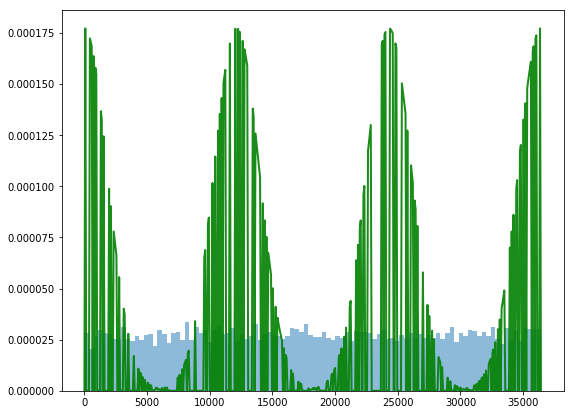

In [392]:
fig, ax2 = plt.subplots(figsize = (9,7))

#Plot histogram
ax2.hist(mylist, bins = 100, alpha = 0.5, density = True)
ax2.plot(grid, pdf, alpha = 0.9, color = 'green', linewidth = 2.0)
plt.show()

In [393]:
df = df.drop(best_outliers)

In [394]:
# Take a look at the outcome variable: Loan Status
print(df['Loan Status'].value_counts())

0.0    16411
1.0     5016
Name: Loan Status, dtype: int64


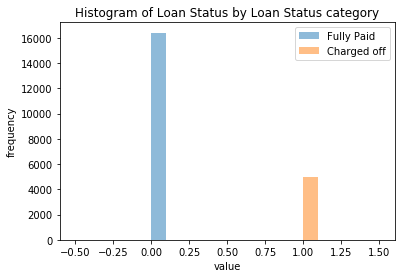

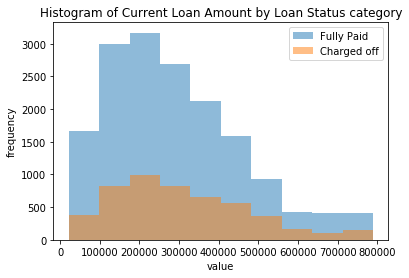

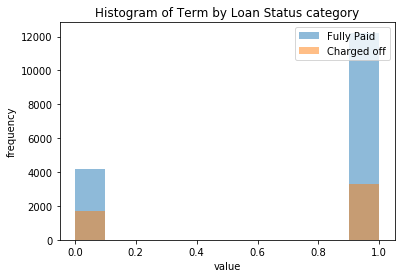

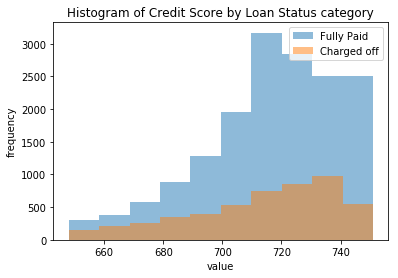

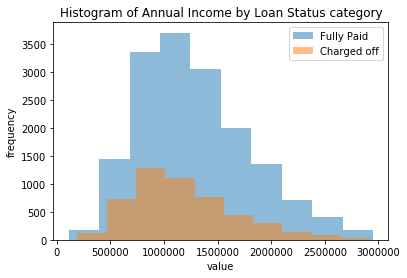

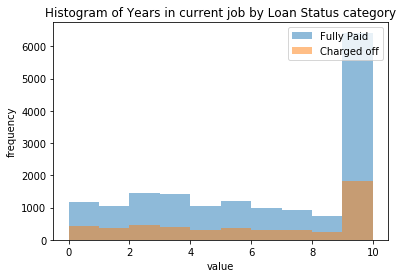

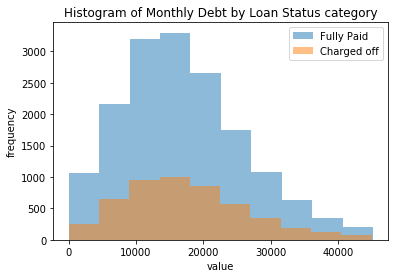

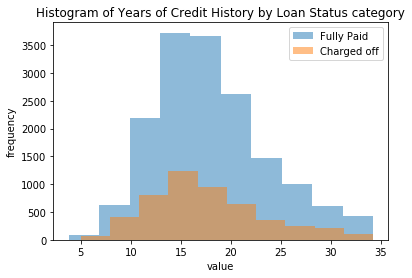

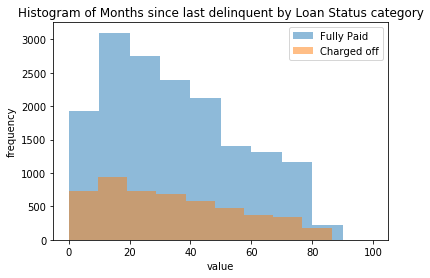

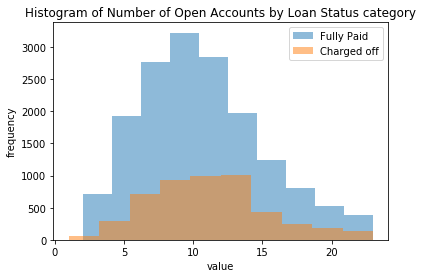

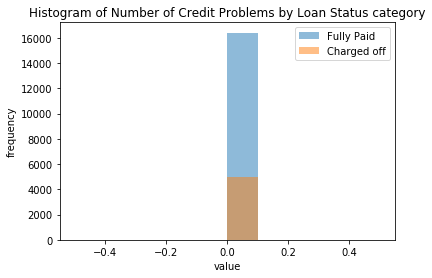

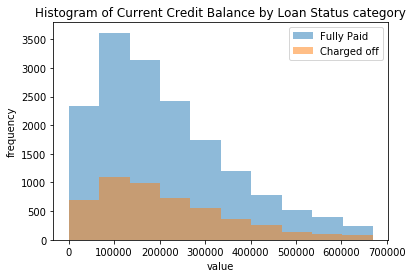

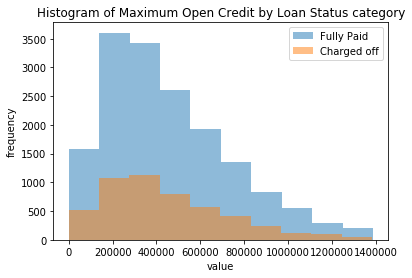

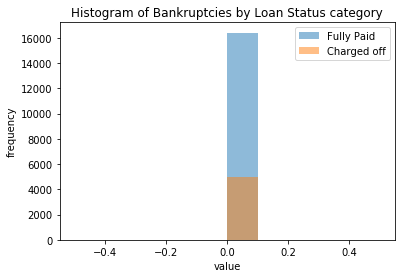

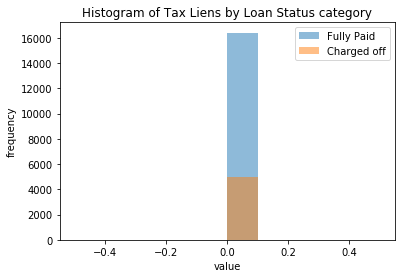

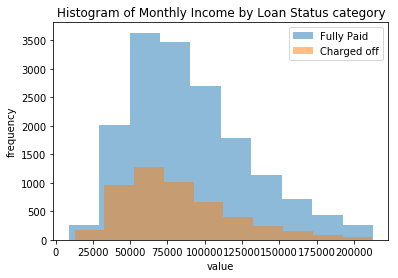

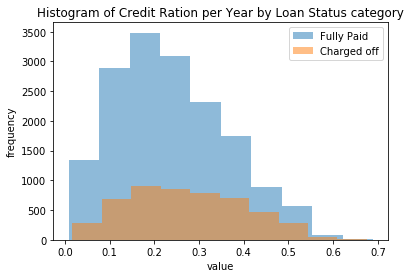

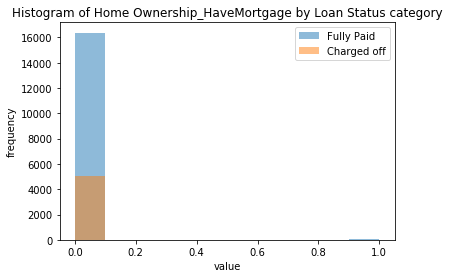

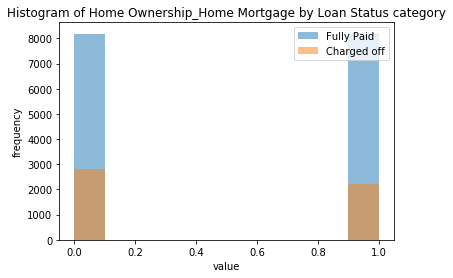

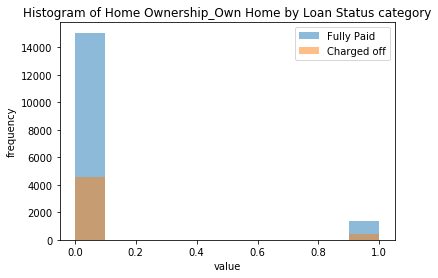

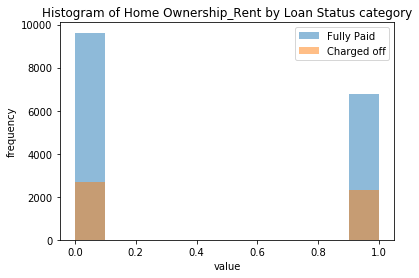

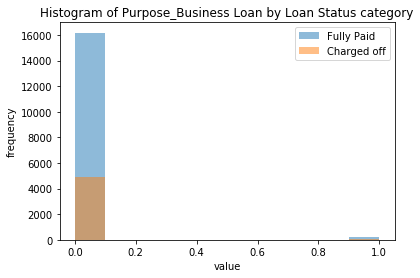

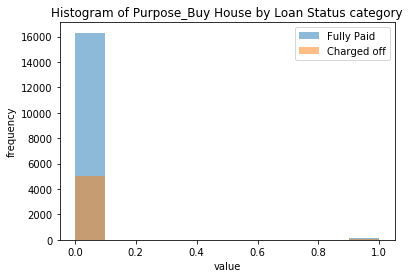

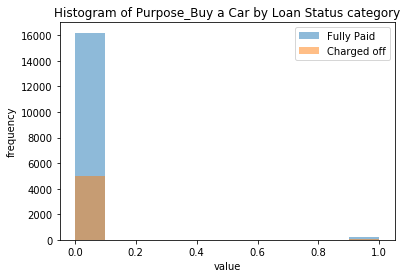

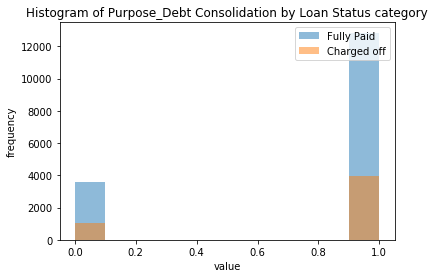

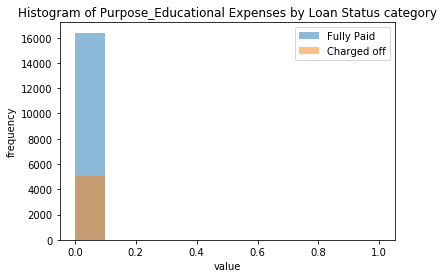

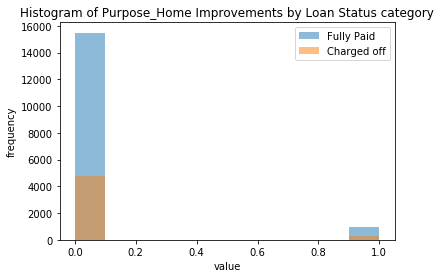

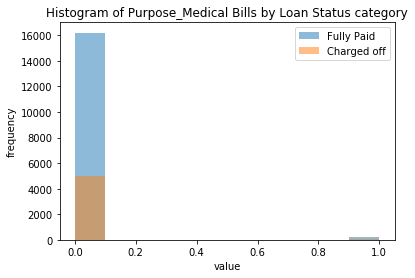

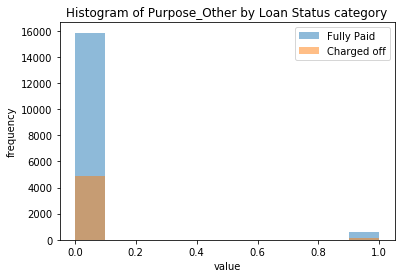

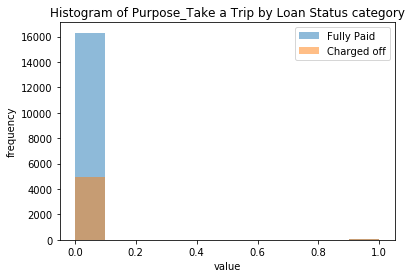

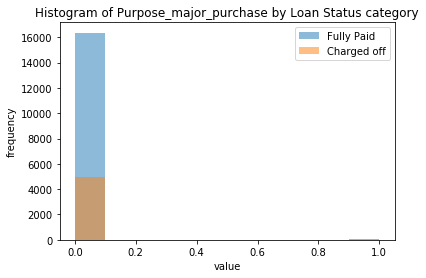

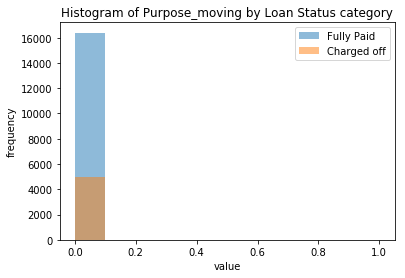

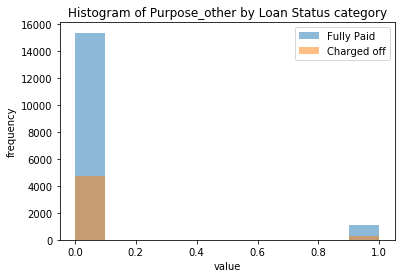

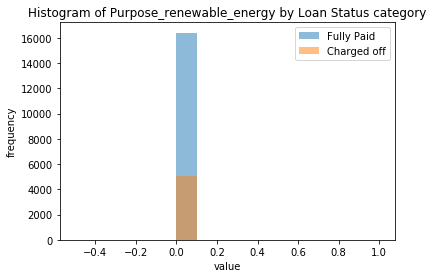

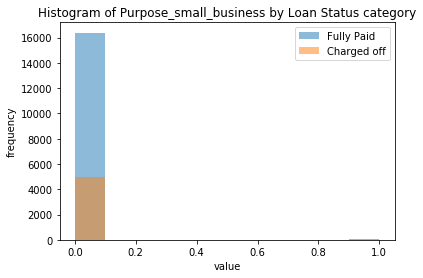

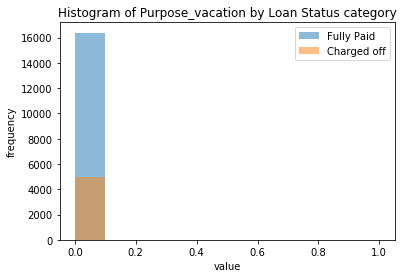

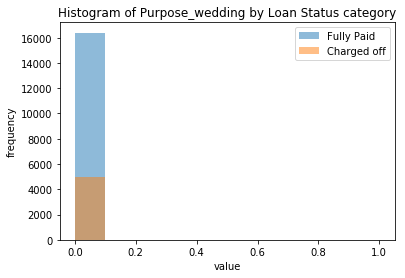

In [395]:
# Distribution of features : Histograms broken up by outcome categories (in this case Loan Status)
def plot_histogram(x,y):
    plt.hist(list(x[y==0]), alpha=0.5, label='Fully Paid')
    plt.hist(list(x[y==1]), alpha=0.5, label='Charged off')
    plt.title('Histogram of {0} by Loan Status category'.format(x.name))
    plt.xlabel("value")
    plt.ylabel("frequency")
    plt.legend(loc='upper right')
    plt.show()
    
for x in df.columns:
    plot_histogram(df[x],df["Loan Status"])

In [396]:
#calculate absolute correlation
corr_abs = abs(df.corr())
corr_abs[['Loan Status']].sort_values(by='Loan Status',ascending=False)

,Loan Status
Loan Status,1.000000
Credit Ration per Year,0.111824
Monthly Income,0.091663
Term,0.083662
Annual Income,0.078622
Credit Score,0.056647
Home Ownership_Home Mortgage,0.049256
Current Loan Amount,0.044956
Home Ownership_Rent,0.043294
Number of Open Accounts,0.032597


In [398]:
corr_abs["Loan Status"].sum(skipna=True)

1.837027934432355

In [ ]:
#save as processed 
df.to_csv(data_folder + "/" + dataset + "_processed__removeoutliers" + file_type)